In [1]:
# Import required libraries and dependencies
import pandas as pd
import hvplot.pandas
import requests
import json
from config import api_key
from pprint import pprint
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
#Multiple time period func
def fetch_data(time_period):
    url = "https://coinranking1.p.rapidapi.com/coins"

    querystring = {"referenceCurrencyUuid":"yhjMzLPhuIDl","timePeriod": time_period,
                   "tiers[0]":"1","orderBy":"marketCap","orderDirection":"desc",
                   "limit":"50","offset":"0"}

    headers = {
        "X-RapidAPI-Key": f"{api_key}",
        "X-RapidAPI-Host": "coinranking1.p.rapidapi.com"
    }
    #API call
    response = requests.get(url, headers=headers, params=querystring)
    #Error formatting
    if response.status_code == 200:
        return pd.DataFrame(response.json()['data']['coins']) 
    else:
        return pd.DataFrame()
    
df_24hr = fetch_data('24h').drop(columns=['iconUrl', 'coinrankingUrl'])
df_7d = fetch_data('7d').drop(columns=['iconUrl', 'coinrankingUrl'])
df_30d = fetch_data('30d').drop(columns=['iconUrl', 'coinrankingUrl'])
df_3m = fetch_data('3m').drop(columns=['iconUrl', 'coinrankingUrl'])
df_1y = fetch_data('1y').drop(columns=['iconUrl', 'coinrankingUrl'])
df_3y = fetch_data('3y').drop(columns=['iconUrl', 'coinrankingUrl'])
df_5y = fetch_data('5y').drop(columns=['iconUrl', 'coinrankingUrl'])

### Prepare the Data

In [3]:
columns_to_drop = ['color', 'listedAt', 'tier', 'lowVolume']

df_24hr_cleaned = df_24hr.drop(columns = columns_to_drop)
df_7d_cleaned = df_7d.drop(columns = columns_to_drop)
df_30d_cleaned = df_30d.drop(columns = columns_to_drop)
df_3m_cleaned = df_3m.drop(columns = columns_to_drop)
df_1y_cleaned = df_1y.drop(columns = columns_to_drop)
df_3y_cleaned = df_3y.drop(columns = columns_to_drop)
df_5y_cleaned = df_5y.drop(columns = columns_to_drop)

In [4]:
# Convert sparkline from obj to float
df_24hr_cleaned['sparkline'] = df_24hr_cleaned['sparkline'].apply(lambda x: [float(i) for i in x])
df_7d_cleaned['sparkline'] = df_7d_cleaned['sparkline'].apply(lambda x: [float(i) for i in x])
df_30d_cleaned['sparkline'] = df_30d_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_3m_cleaned['sparkline'] = df_3m_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_1y_cleaned['sparkline'] = df_1y_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_3y_cleaned['sparkline'] = df_3y_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_5y_cleaned['sparkline'] = df_5y_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])

# Function to calculate rolling mean
def calculate_latest_rolling_mean(lst, window=5):
#     lst = [float(x) for x in lst]
    if len(lst) < window:
        return 
    else:
        return np.mean(lst[-window:])
               
df_24hr_cleaned['latest_moving_avg'] = df_24hr_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_7d_cleaned['latest_moving_avg'] = df_7d_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_30d_cleaned['latest_moving_avg'] = df_30d_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_3m_cleaned['latest_moving_avg'] = df_3m_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_1y_cleaned['latest_moving_avg'] = df_1y_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_3y_cleaned['latest_moving_avg'] = df_3y_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_5y_cleaned['latest_moving_avg'] = df_5y_cleaned['sparkline'].apply(calculate_latest_rolling_mean)

In [5]:
features = df_24hr_cleaned[['marketCap', 'price', 'change',  '24hVolume', 'latest_moving_avg']]

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Cluster Coins

C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

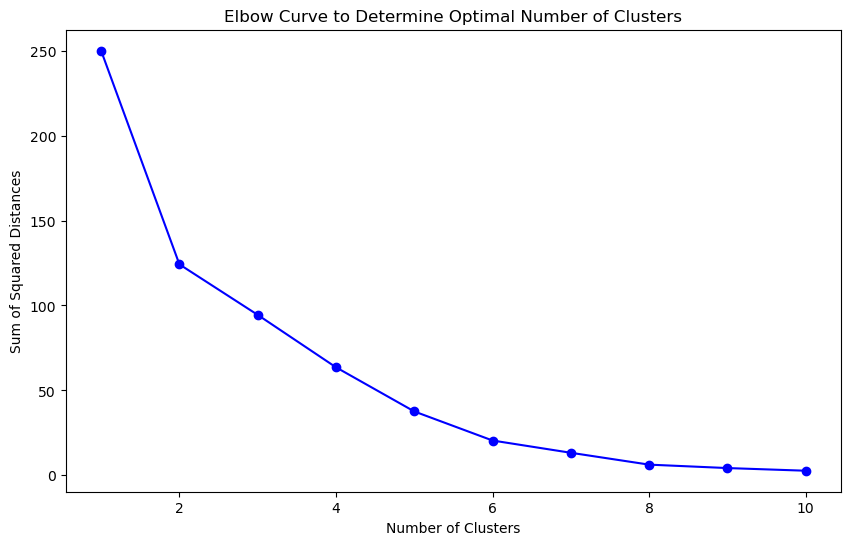

In [7]:
#Elbow Curve
# Determine range for k (e.g., 1 to 10 clusters)
range_n_clusters = list(range(1,11))
sum_of_squared_distances = []

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans = kmeans.fit(scaled_features)
    
    # Append the inertia (SSD) to the list
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10,6))
plt.plot(range_n_clusters, sum_of_squared_distances, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve to Determine Optimal Number of Clusters')
plt.show()

In [8]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(scaled_features)

C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [9]:
df_24hr_cleaned['cluster'] = clusters
df_24hr_clustered = df_24hr_cleaned.copy()

In [10]:
merged_data = df_24hr_clustered.merge(df_1y_cleaned, on='symbol', suffixes=('_24hr', '_1y'))
merged_data.head()

,uuid_24hr,symbol,name_24hr,marketCap_24hr,price_24hr,change_24hr,rank_24hr,sparkline_24hr,24hVolume_24hr,btcPrice_24hr,...,uuid_1y,name_1y,marketCap_1y,price_1y,change_1y,rank_1y,sparkline_1y,24hVolume_1y,btcPrice_1y,latest_moving_avg_1y
0,Qwsogvtv82FCd,BTC,Bitcoin,506439088393,25992.762641521087,2.90,1,"[25267.3712678228, 25614.72187270757, 25891.14...",17602334782,1,...,Qwsogvtv82FCd,Bitcoin,506439088393,25992.762641521087,16.05,1,"[19820.700505355522, 19631.646983618004, 17692...",17602334782,1,22876.655593
1,razxDUgYGNAdQ,ETH,Ethereum,195301667377,1600.0913838887436,2.58,2,"[1559.9964461188279, 1575.8010809813825, 1588....",10432270883,0.06155911189419867,...,razxDUgYGNAdQ,Ethereum,195301667377,1600.0913838887436,-6.79,2,"[1488.1610777547928, 1364.9769066327108, 1307....",10432270883,0.06155911189419867,1498.570821
2,HIVsRcGKkPFtW,USDT,Tether USD,83196153102,1.0020494774490243,-0.20,3,"[1.0036775566076883, 0.9992396704851003, 1.001...",25237891527,0.000038551095597985,...,HIVsRcGKkPFtW,Tether USD,83196153102,1.0020494774490243,0.25,3,"[1.0003281517181468, 1.0003818174423569, 1.000...",25237891527,0.000038551095597985,0.802438
3,WcwrkfNI4FUAe,BNB,BNB,32379607750,211.7225240796585,2.67,4,"[206.25324280721904, 208.34885377441765, 209.8...",360702536,0.00814544136764635,...,WcwrkfNI4FUAe,BNB,32379607750,211.7225240796585,-27.93,4,"[278.16384177339125, 281.4639170880019, 299.17...",360702536,0.00814544136764635,227.765782
4,aKzUVe4Hh_CON,USDC,USDC,26267255140,1.002300609161041,-0.20,5,"[1.0038639989835494, 0.9992373388268215, 1.001...",5927483603,0.000038560757199389,...,aKzUVe4Hh_CON,USDC,26267255140,1.002300609161041,0.27,5,"[1.000295825280198, 1.0003581417782612, 1.0008...",5927483603,0.000038560757199389,0.802074


In [11]:
# sample_sparkline = df_1y_cleaned['sparkline'].iloc[0]  # Get the sparkline values for the first row
# num_points = len(sample_sparkline)
# print(f"The number of sparkline points in the 3-month dataset is: {num_points}")

# SMA's

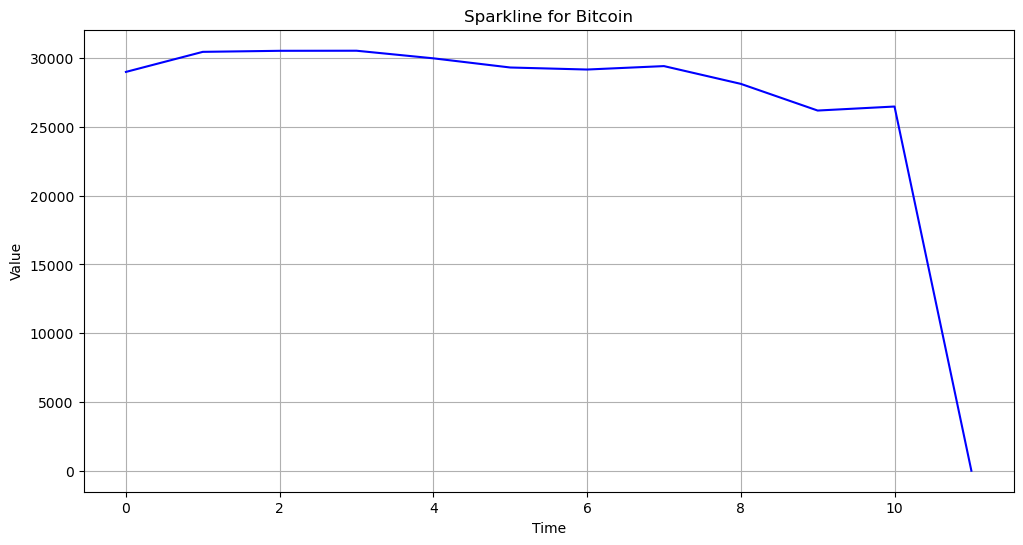

In [18]:
df_sparklines = df_3m_cleaned[['symbol', 'sparkline']]

df_sparklines_explode = df_sparklines.explode('sparkline').reset_index(drop=True)

df_sparklines_explode.fillna(0)
df_sparklines_explode['sparkline'] = df_sparklines_explode['sparkline'].astype(float)

coin_data = df_sparklines_explode[df_sparklines_explode['symbol'] == 'BTC']  # For Bitcoin, for example

plt.figure(figsize=(12, 6))
plt.plot(coin_data['sparkline'], color='blue')
plt.title('Sparkline for Bitcoin')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [31]:
#Compute fast&slow SMA's
def fractional_rollingmean(data, before_frac, after_frac):
    kernel = [before_frac, 1, after_frac]
    return np.convolve(data, kernel, mode='same') / sum(kernel)

df_sparklines_explode['fast_SMA'] = df_sparklines_explode.groupby('symbol')['sparkline'].transform(lambda x: fractional_rollingmean(x,0.5,0.5))
df_sparklines_explode['slow_SMA'] = df_sparklines_explode.groupby('symbol')['sparkline'].transform(lambda x: fractional_rollingmean(x,1.5,1.5))

In [32]:
# Create a column for the signal (1 for buy, -1 for sell, 0 for hold)
df_sparklines_explode['signal'] = 0 #default to hold
df_sparklines_explode.loc[df_sparklines_explode['fast_SMA'] > df_sparklines_explode['slow_SMA'], 'signal'] = 1
df_sparklines_explode.loc[df_sparklines_explode['fast_SMA'] < df_sparklines_explode['slow_SMA'], 'signal'] = -1
df_sparklines_explode.dtypes

symbol        object
sparkline    float64
fast_SMA     float64
slow_SMA     float64
signal         int64
dtype: object

# Labeling Analysis

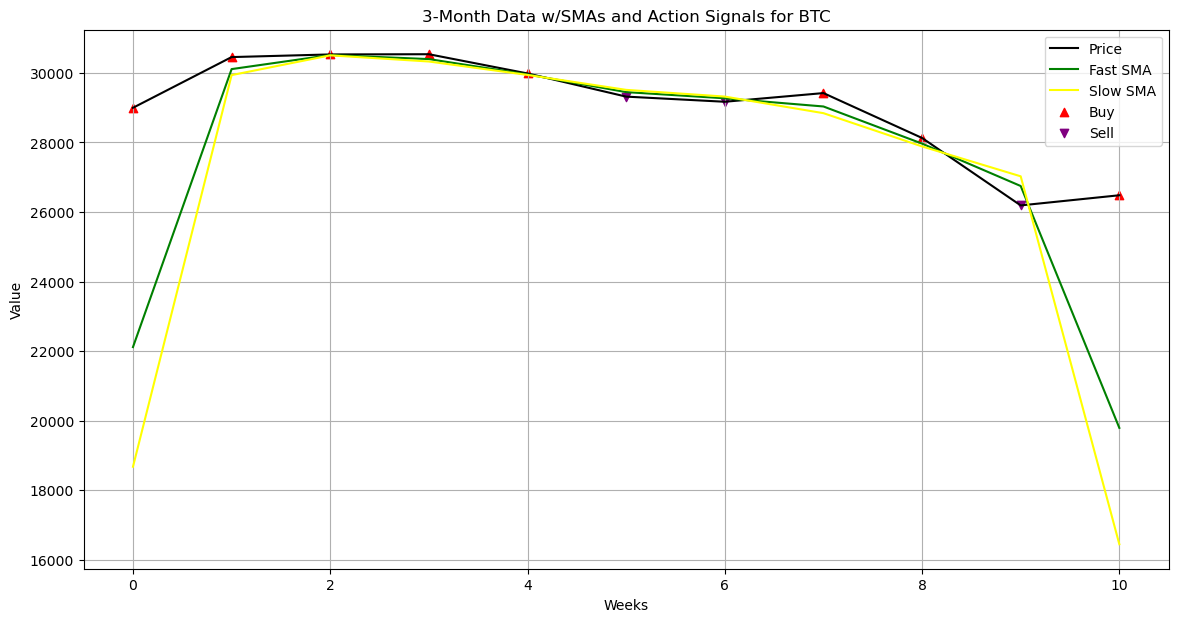

In [33]:
coin = 'BTC'#Replace BTC with any coin symbol
coin_data = df_sparklines_explode[df_sparklines_explode['symbol']== coin]
coin_data_filtered = coin_data[coin_data['sparkline'] != 0]#Exclude any null price points
plt.figure(figsize=(14,7))
plt.plot(coin_data_filtered['sparkline'], label='Price', color='blue')
plt.plot(coin_data_filtered['fast_SMA'], label='Fast SMA', color='green')
plt.plot(coin_data_filtered['slow_SMA'], label='Slow SMA', color='yellow')
plt.scatter(coin_data_filtered.index, coin_data_filtered['sparkline'].where(coin_data_filtered['signal'] == 1), color='red', label='Buy', marker='^', alpha=1)
plt.scatter(coin_data_filtered.index, coin_data_filtered['sparkline'].where(coin_data_filtered['signal'] == -1), color='purple', label='Sell', marker='v', alpha=1)
plt.title(f'3-Month Data w/SMAs and Action Signals for {coin}')
plt.xlabel('Weeks')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


---

In [27]:
print(coin_data_filtered['sparkline'].describe())

count       11.000000
mean     29021.105686
std       1520.485560
min      26190.056709
25%      28564.351812
50%      29320.044071
75%      30221.969160
max      30539.846458
Name: sparkline, dtype: float64
